In [30]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [31]:
def sift(im1, im2, path):
    sift = cv.SIFT_create()
    kp1, d1 = sift.detectAndCompute(im1, None)
    kp2, d2 = sift.detectAndCompute(im2, None)
    image_keypoints = cv.drawKeypoints(im1, kp1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    path = path+"/_keypoints.png"
    cv.imwrite(path, image_keypoints)
    
    return kp1, kp2, d1, d2

In [41]:
def matchKeypoints(im1, im2, kp1, kp2, d1, d2, p):

    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(d1,d2, k=2)
    # Apply ratio test
    good = []
    pt1 = []
    pt2 = []
    for m,n in matches:
        if m.distance < 0.9*n.distance:
            good.append([m])
            pt1.append(kp1[m.queryIdx].pt)
            pt2.append(kp2[m.trainIdx].pt)
            
    # cv2.drawMatchesKnn expects list of lists as matches.
    result_img = cv.drawMatchesKnn(im1,kp1,im2,kp2,good, None, flags=2)
    path = p+"/_matched_keypoints.png"
    cv.imwrite(path, result_img)
    
    return pt1, pt2

In [42]:
def calcFundamentalMatrix(pt1, pt2):
    pt1 = np.int32(pt1)
    pt2 = np.int32(pt2)
    fm, inliers = cv.findFundamentalMat(pt1, pt2, cv.FM_RANSAC)
    #selecting only the inliers. 
    pt1 = pt1[inliers.ravel() == 1]
    pt2 = pt2[inliers.ravel() == 1]
    
    return pt1, pt2, fm

In [43]:
def rectify(pt1, pt2, im1, im2, fm, path):
#corresponding epiline are drawn
    
    h1, w1 = im1.shape
    h2, w2 = im2.shape
    _, HF1, HF2 = cv.stereoRectifyUncalibrated(np.float32(pt1), np.float32(pt2),fm, imgSize=(w1, h1))
    im1_rect = cv.warpPerspective(im1, HF1, (w1, h1))
    im2_rect = cv.warpPerspective(im2, HF2, (w2, h2))
    
    #saving rectified images
    path1 = path+"/_rectifiedView1.png"
    path2 = path+"/_rectifiedView2.png"
    cv.imwrite(path1, im1_rect)
    cv.imwrite(path2, im2_rect)

    return im1_rect, im2_rect

In [44]:
def calcDisparityMap(im1, im2, path):
    stereo = cv.StereoSGBM_create(
        P1=420,
        P2=2869,
        blockSize=9,
        speckleRange=5,
        disp12MaxDiff=0,
        uniquenessRatio=3,
        minDisparity=-128,
        numDisparities=256,
        speckleWindowSize=25
    )

    computed_disparity= stereo.compute(im1, im2)
    computed_disparity_norm = cv.normalize(computed_disparity, computed_disparity, alpha=255, beta=0, norm_type=cv.NORM_MINMAX)
    computed_disparity_norm = np.uint8(computed_disparity_norm)
    path = path+"/disp1.png"
    plt.imshow(computed_disparity_norm)
    plt.colorbar()
    plt.show()
    cv.imwrite(path, computed_disparity_norm)


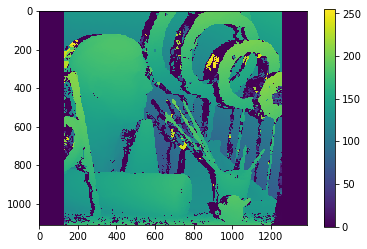

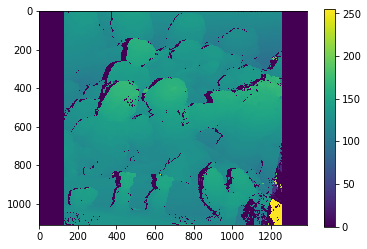

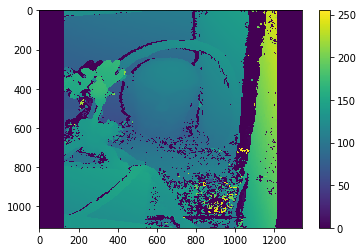

In [45]:
if __name__=="__main__":
    
    folders=["Art", "Dolls","Reindeer"]
    
    for p in folders:
        
        path1="StereoMatchingTestings/"+p+"/view1.png"
        path2="StereoMatchingTestings/"+p+"/view5.png"
        
        im1 = cv.imread(path1, cv.IMREAD_GRAYSCALE)
        im2 = cv.imread(path2, cv.IMREAD_GRAYSCALE)
        
        kp1, kp2, d1, d2=sift(im1, im2, "Results/"+p)
        
        pt1, pt2 = matchKeypoints(im1, im2, kp1, kp2, d1, d2, "Results/"+p)
        
        pt1, pt2, fm = calcFundamentalMatrix(pt1, pt2)
        
        im1_rect, im2_rect = rectify(pt1, pt2, im1, im2, fm, "Results/"+p)
        
        calcDisparityMap(im1_rect, im2_rect, "Results/"+p)

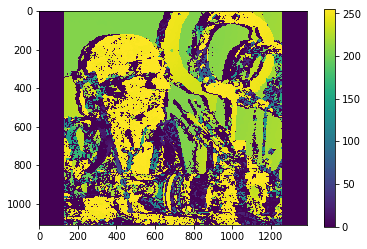

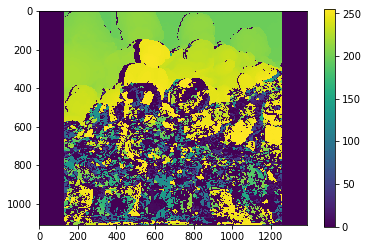

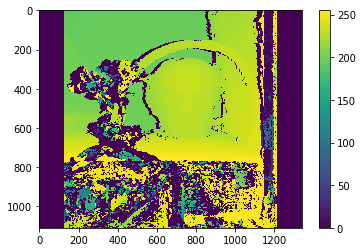

In [38]:
j=["Art", "Dolls","Reindeer"]
for p in j:
    path1="StereoMatchingTestings/"+p+"/view1.png"
    path2="StereoMatchingTestings/"+p+"/view5.png"
    im1 = cv.imread(path1, cv.IMREAD_GRAYSCALE)
    im2 = cv.imread(path2, cv.IMREAD_GRAYSCALE)
    calcDisparityMap(im1, im2, "Results/pred/"+p)
        